In [1]:
# Importación de bibliotecas estándar
import numpy as np
import pandas as pd

# Importación de bibliotecas para visualización
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches

# Importando itertools para generar combinaciones de columnas
import itertools 

# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

# Importación de herramientas para modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler

# Importación de módulo personalizado
import payments_manager as pm

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [2]:
# One Hot econding para pasar a numéricas todas las categóricas
df_jo_cp = pd.get_dummies(df_jo_cp, columns=['transfer_type'], drop_first=True, dtype=int)
df_jo_cp = pd.get_dummies(df_jo_cp, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [3]:
# SEGMENTACIONES EN DATAFRAMES USUARIOS REPETITIVOS Y NUEVOS

# Ordenar por 'created_at' para asegurar que la primera acción esté en la parte superior
df_jo_cp_sorted = df_jo_cp.sort_values('created_at')
count_all = df_jo_cp_sorted.shape[0]

# 2. Identificar usuarios con más de una acción (usuarios repetitivos)

repeat_users_df = df_jo_cp[(df_jo_cp['n_fees'] > 1) | (df_jo_cp['n_backs'] > 1) | (df_jo_cp['n_recovery'] > 1) | (df_jo_cp['n_inc_back'] > 1)| (df_jo_cp['n_inc_fees'] > 1)]

# Sort and group by user_id, keeping repetitive activities
repeat_users_df = repeat_users_df.sort_values('created_at').reset_index(drop=True)

# Obtener los usuarios nuevos (aquellos con solo una acción)

new_users_df = df_jo_cp[(df_jo_cp['n_fees'] <= 1) & (df_jo_cp['n_backs'] <= 1) & (df_jo_cp['n_recovery'] <= 1) & (df_jo_cp['n_inc_back'] <= 1) & (df_jo_cp['n_inc_fees'] <= 1)]


new_users_df = new_users_df.sort_values('created_at').groupby('user_id').first().reset_index()

# Número de filas de nuevos usuarios
count_new_users = new_users_df.shape[0]

# Número de filas de usuarios repetitivos
count_repeat_users = repeat_users_df.shape[0]

# Imprimir resultados
print(f'Número de filas en el DataFrame original: {count_all}')
print(f'Número de filas en el DataFrame de nuevos usuarios: {count_new_users}')
print(f'Número de filas en el DataFrame de usuarios repetitivos: {count_repeat_users}')

Número de filas en el DataFrame original: 32092
Número de filas en el DataFrame de nuevos usuarios: 11938
Número de filas en el DataFrame de usuarios repetitivos: 18808


In [4]:
# VERIFICACION DE BALANCEO DE CLASES

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts_all = df_jo_cp['needs_m_check_recov'].value_counts()
value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
total_all = value_counts_all[0] + value_counts_all[1]
total_new = value_counts_new[0] + value_counts_new[1]
total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual_all = (value_counts_all[1] / total_all) * 100
needs_manual_new = (value_counts_new[1] / total_new) * 100
needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')

Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
Porcentaje de operaciones con needs_m_check del clientes nuevos: 42.08 %
Porcentaje de operaciones con needs_m_check del clientes repetitivos: 57.83 %


In [5]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type_regular','n_recovery', 'n_fees', 'n_backs','n_inc_back','n_inc_fees','GBP_EUR','BTC_GBP','inflation', 'unemploy_rate','amount','charge_moment_before','n_cr_fe_w','category_nice','category_rejected_direct_debit','needs_m_check_recov']
# Rellenar NaN con 0
df_jo_cp [columnas_deseadas] = df_jo_cp[columnas_deseadas].fillna(0)

In [6]:
df_jo_cp[columnas_deseadas]

,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit,needs_m_check_recov
0,13,1,1,0,0,0,1,0,1.16935,6347.577148,1.3,3.9,1.0,0,0.0,0,0,1
1,14,0,1,0,0,1,0,0,1.18803,5630.115723,1.3,4.0,100.0,0,1.0,0,0,0
2,19,1,1,0,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
3,19,1,1,1,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
4,19,1,1,0,0,0,1,0,1.18800,5543.707520,1.3,4.0,100.0,0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,23,6,0,0,2,2,1,0,0.00000,10627.522461,0.7,5.3,50.0,0,1.0,1,0,0
32088,23,6,0,0,3,3,0,0,0.00000,10627.522461,0.7,5.3,100.0,0,1.0,1,0,0
32089,23,6,0,3,2,2,4,4,0.00000,10627.522461,0.7,5.3,50.0,0,0.0,0,0,1
32090,23,6,0,0,1,1,0,0,0.00000,10627.522461,0.7,5.3,60.0,0,1.0,1,0,0


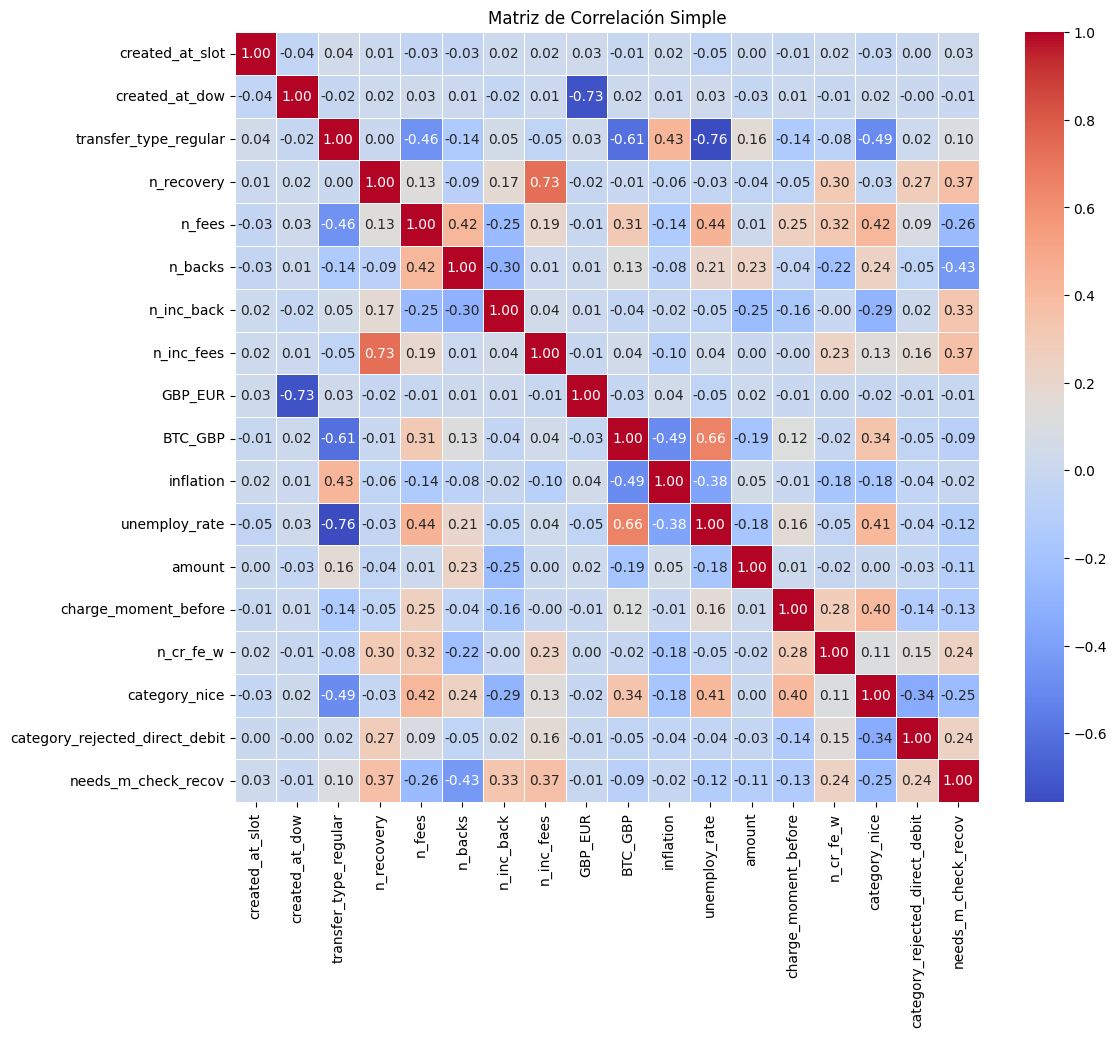

In [7]:
# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = repeat_users_df[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()


In [8]:
# BALANCEO DE CARGAS

columns = df_simpl.columns
X_b = df_simpl.drop('needs_m_check_recov', axis=1)
y_b = df_simpl['needs_m_check_recov']

undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X_b, y_b)

columns_X = np.delete(columns, 14)
columns_y = columns[-1]

print(pd.Series(y_under).value_counts())

X_b_df = pd.DataFrame(X_under, columns=columns_X)
y_b_df = pd.DataFrame(y_under, columns=[columns_y])

balanced_df = pd.concat([X_b_df, y_b_df], axis=1)

needs_m_check_recov
0    7931
1    7931
Name: count, dtype: int64


/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/home/albagd/ProyectoPastaLoca2/myenv/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [9]:
# Rellenar NaN con 0
df_simpl = df_simpl.fillna(0)

In [10]:
# Visualización datos antes del escalador
display(df_simpl.head(10))

# Sacamos la variable objetivo que no se va a escalar
y = df_simpl['needs_m_check_recov']
df_simpl = df_simpl.drop(columns=['needs_m_check_recov'])

# Crear el escalador en este caso STANDARDSCALER
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df_simpl)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=df_simpl.columns, index=df_simpl.index)

# Visualización datos después del escalador
display(X.head(10))

,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit,needs_m_check_recov
0,14,3,1,0,0,0,2,0,1.18557,5376.049805,1.3,4.0,100.0,0,0.0,0,0,1
1,16,3,1,0,0,0,2,0,1.17670,5532.994629,1.3,4.0,100.0,0,0.0,0,0,1
2,23,4,1,0,0,0,2,0,1.17000,5551.017090,1.3,4.0,50.0,0,0.0,0,0,1
3,11,5,1,1,0,0,2,0,0.00000,5529.749023,1.3,4.0,50.0,0,0.0,0,0,1
4,12,5,1,0,0,0,2,0,0.00000,5529.749023,1.3,4.0,50.0,0,0.0,0,0,1
5,15,5,1,0,0,0,2,0,0.00000,5529.749023,1.3,4.0,100.0,0,0.0,0,0,1
6,21,5,1,0,0,0,2,0,0.00000,5529.749023,1.3,4.0,100.0,0,0.0,0,0,1
7,15,0,1,1,0,0,2,0,1.17366,5683.289551,1.3,4.0,100.0,0,0.0,0,0,1
8,3,3,1,0,0,0,2,0,1.16890,5569.683105,1.3,4.0,100.0,0,0.0,0,0,1
9,9,4,1,0,0,2,0,0,1.17085,5573.462402,1.3,4.0,100.0,0,1.0,0,0,0


,created_at_slot,created_at_dow,transfer_type_regular,n_recovery,n_fees,n_backs,n_inc_back,n_inc_fees,GBP_EUR,BTC_GBP,inflation,unemploy_rate,amount,charge_moment_before,n_cr_fe_w,category_nice,category_rejected_direct_debit
0,0.248357,0.130776,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,0.678370,-3.357048,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
1,0.621686,0.130776,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,0.658389,-3.176771,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
2,1.928340,0.677969,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,0.643297,-3.156069,2.375233,-2.872336,-1.53939,-0.477154,-1.151922,-1.203594,-0.284682
3,-0.311637,1.225162,1.242036,-0.051038,-0.982869,-1.238197,0.289136,-0.645397,-1.992220,-3.180499,2.375233,-2.872336,-1.53939,-0.477154,-1.151922,-1.203594,-0.284682
4,-0.124972,1.225162,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,-1.992220,-3.180499,2.375233,-2.872336,-1.53939,-0.477154,-1.151922,-1.203594,-0.284682
5,0.435022,1.225162,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,-1.992220,-3.180499,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
6,1.555010,1.225162,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,-1.992220,-3.180499,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
7,0.435022,-1.510803,1.242036,-0.051038,-0.982869,-1.238197,0.289136,-0.645397,0.651541,-3.004132,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
8,-1.804955,0.130776,1.242036,-0.523906,-0.982869,-1.238197,0.289136,-0.645397,0.640819,-3.134628,2.375233,-2.872336,0.58598,-0.477154,-1.151922,-1.203594,-0.284682
9,-0.684967,0.677969,1.242036,-0.523906,-0.982869,0.017086,-0.627753,-0.645397,0.645212,-3.130287,2.375233,-2.872336,0.58598,-0.477154,-0.129923,-1.203594,-0.284682


Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_recovery: 0.90376756
n_backs: -0.67030582
n_inc_fees: 0.65138476
n_cr_fe_w: -0.63709749
n_fees: -0.51949425
category_rejected_direct_debit: 0.51613616
transfer_type_regular: -0.33742230
n_inc_back: 0.30488904
inflation: -0.24368150
category_nice: -0.19856394
unemploy_rate: 0.17658863
charge_moment_before: -0.09751709
GBP_EUR: -0.04515676
created_at_dow: -0.01845683
amount: 0.01191394
created_at_slot: 0.00134810
BTC_GBP: -0.00000962

Multiplicadores de odds (elevando exp a los coeficientes):
n_recovery: 2.46888730
n_backs: 0.51155211
n_inc_fees: 1.91819523
n_cr_fe_w: 0.52882512
n_fees: 0.59482130
category_rejected_direct_debit: 1.67554111
transfer_type_regular: 0.71360742
n_inc_back: 1.35647448
inflation: 0.78373721
category_nice: 0.81990735
unemploy_rate: 1.19314017
charge_moment_before: 0.90708684
GBP_EUR: 0.95584763
created_at_dow: 0.98171245
amount: 1.01198519
created_at_slot: 1.00134901
BTC_GBP: 0.99999038


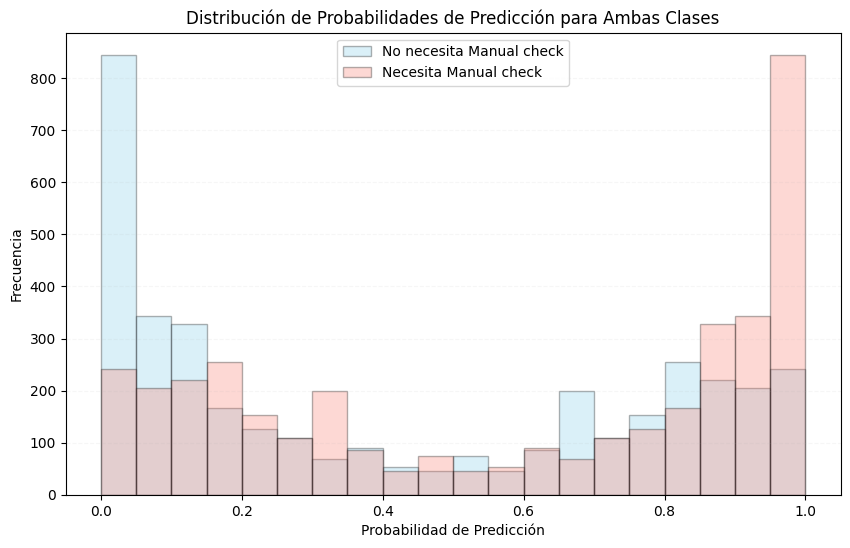

Accuracy: 0.8965975544922913
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1507
           1       0.93      0.90      0.91      2255

    accuracy                           0.90      3762
   macro avg       0.89      0.90      0.89      3762
weighted avg       0.90      0.90      0.90      3762



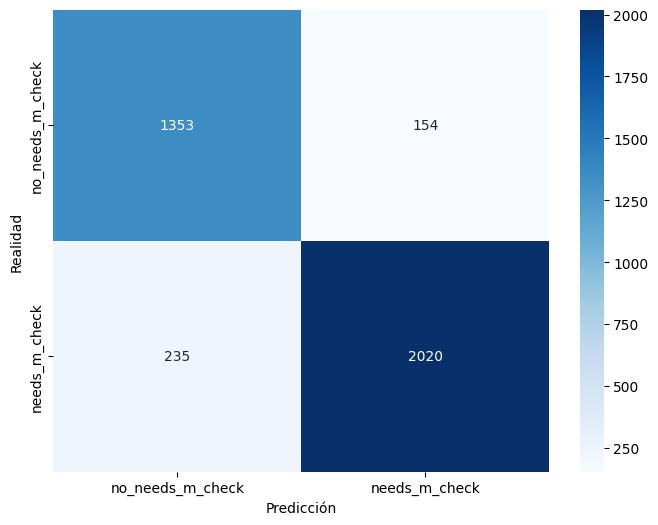

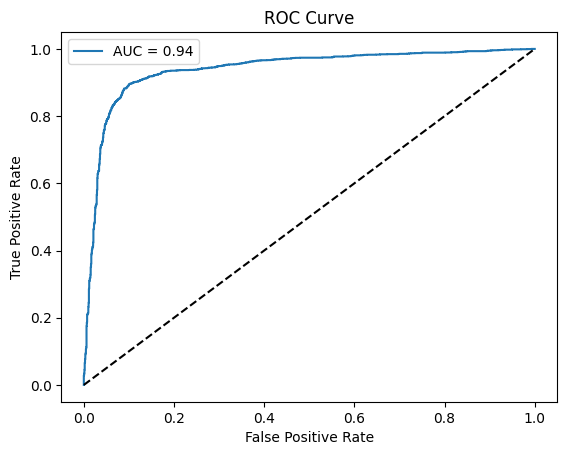

In [11]:
# Pasamos MODELO DE REGRESIÓN LOGISTICA BASE, con todas las caracteristicas para poder ver después la diferencia al aplicar Ridge y Lasso
X=df_simpl

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Convertir coeficientes a multiplicadores de odds
feature_odds = [(feature, np.exp(coef)) for feature, coef in feature_coef_sorted]

# Imprimir los resultados
print("\nMultiplicadores de odds (elevando exp a los coeficientes):")
for feature, odds in feature_odds:
    print(f"{feature}: {odds:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (no need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Histograma para la clase positiva ( need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [12]:
# Probar modificando el umbral. Cambio a 0.4 (por ejemplo)
umbral = 0.4
predicciones_modificadas = (predicciones_probabilidades[:, 1] >= umbral).astype(int)

Accuracy: 0.8965975544922913
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1507
           1       0.90      0.92      0.91      2255

    accuracy                           0.89      3762
   macro avg       0.89      0.89      0.89      3762
weighted avg       0.89      0.89      0.89      3762



Text(70.5815972222222, 0.5, 'Realidad')

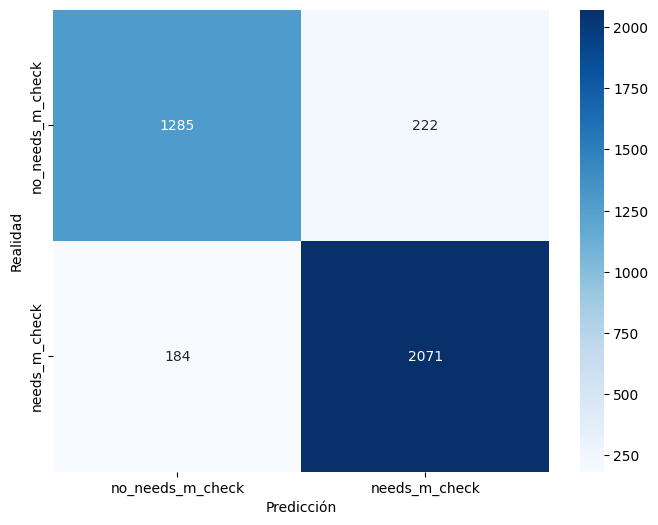

In [13]:
# Evaluate model performance con umbral modificado
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones_modificadas))  # Classification report

# Genera la matriz de confusión
matriz_confusion2 = confusion_matrix(y_test, predicciones_modificadas)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

In [14]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Logistica al modelo base 

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=42, max_iter=2000) #probar tb con solver='liblinear'
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=10, random_state=42, max_iter=2000)
logreg_l2.fit(X_train, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test)
y_pred_l2 = logreg_l2.predict(X_test)

# Evaluación (por ejemplo, exactitud)
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.8984582668793195
Exactitud L2 (Ridge): 0.896863370547581


In [15]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l1 = list(zip(feature_names, coefs))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("\nCaracterísticas importantes para LASSO ordenadas por magnitud:")
print(importancia_no_nula)


Características importantes para LASSO ordenadas por magnitud:
                    Característica  Coeficiente
16  category_rejected_direct_debit     8.802702
3                       n_recovery     0.927815
5                          n_backs    -0.766381
14                       n_cr_fe_w    -0.760113
4                           n_fees    -0.729817
7                       n_inc_fees     0.722819
2            transfer_type_regular    -0.651650
10                       inflation    -0.526012
11                   unemploy_rate     0.340939
6                       n_inc_back     0.337869
13            charge_moment_before     0.226262
15                   category_nice     0.113530
8                          GBP_EUR    -0.048444
12                          amount     0.013719
1                   created_at_dow    -0.013235
0                  created_at_slot     0.000502
9                          BTC_GBP    -0.000197


In [16]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear una lista con características y sus coeficientes
feature_coef_l2 = list(zip(feature_names, coefs2))

# Ordenar las características por el valor absoluto del coeficiente en orden descendente
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': feature_names,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
3                       n_recovery     0.904350
5                          n_backs    -0.670650
7                       n_inc_fees     0.651966
14                       n_cr_fe_w    -0.637343
4                           n_fees    -0.519715
16  category_rejected_direct_debit     0.515849
2            transfer_type_regular    -0.337177
6                       n_inc_back     0.304425
10                       inflation    -0.243553
15                   category_nice    -0.198712
11                   unemploy_rate     0.176395
13            charge_moment_before    -0.097693
8                          GBP_EUR    -0.045249
1                   created_at_dow    -0.017982
12                          amount     0.011910
0                  created_at_slot     0.001354
9                          BTC_GBP    -0.000010


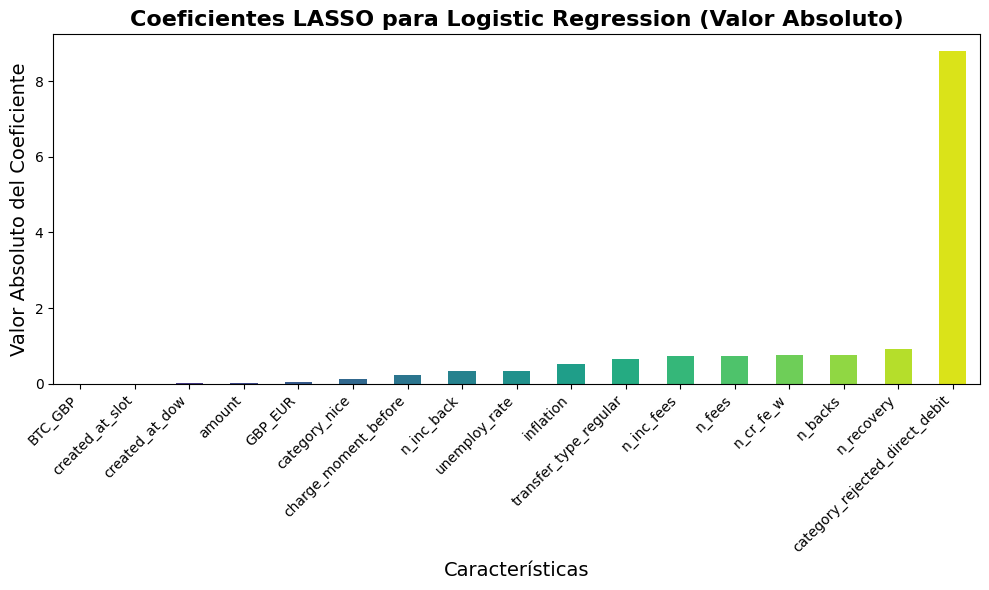

In [17]:
# Graficamos los coeficientes ordenados por valor absoluto LASSO
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l1 = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l1 = coefs_series_l1.abs().sort_values(ascending=True)

# graficar
coefs_series_l1.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l1)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

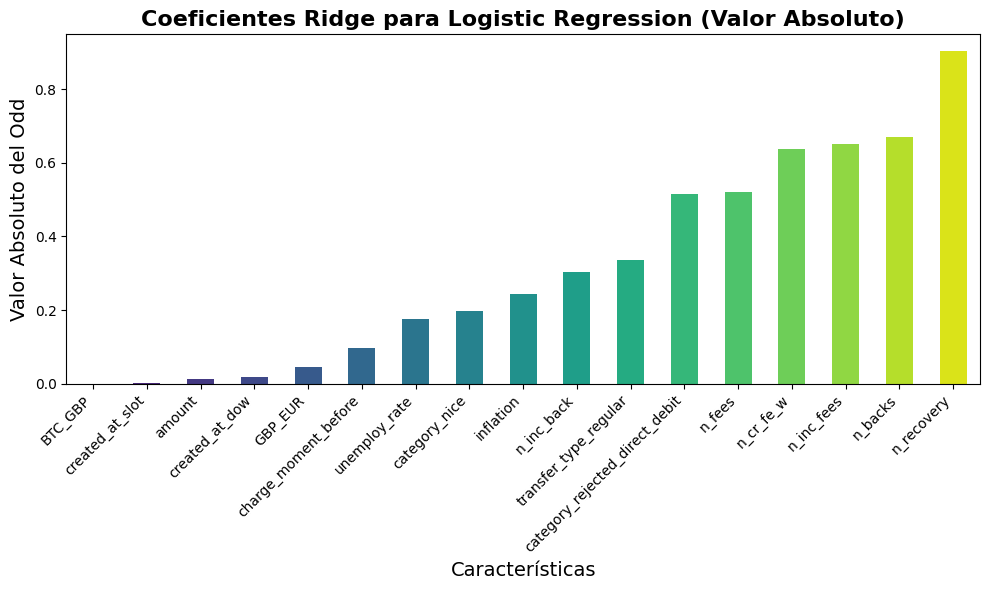

In [18]:
# Graficamos los coeficientes ordenados por valor absoluto RIDGE
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series_l2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series_l2 = coefs_series_l2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series_l2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series_l2)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Odd', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [19]:
#Cálculo C optima de manera manual. LO DEJO COMENTADO PORQUE TARDA 11MINUTOS EN PROCESARSE

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)
scores_l1 = []
scores_l2 = []

# Iterar manualmente para penalización L1
for C in C_values:
    model_l1 = LogisticRegression(
        C=C, penalty='l1', solver='liblinear', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l1, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l1.append(score)

# Iterar manualmente para penalización L2
for C in C_values:
    model_l2 = LogisticRegression(
        C=C, penalty='l2', solver='liblinear', max_iter=1000, random_state=42
    )
    score = cross_val_score(model_l2, X_train, y_train, cv=5, scoring='accuracy').mean()
    scores_l2.append(score)

# Encontrar el mejor C
optimal_C_l1 = C_values[np.argmax(scores_l1)]
optimal_C_l2 = C_values[np.argmax(scores_l2)]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 2.782559402207126
Mejor valor de C para penalización L2: 0.046415888336127774


In [20]:
# Buscamos el C optimo (el alpha optimo) para estas penalizaciones. Ahora con el LogisticRegressionCV que tiene Validación Cruzada incorporada.

# Definir valores de C para probar
C_values = np.logspace(-4, 4, 10)

# Modelo con penalización L1
logreg_l1 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l1',
    solver='liblinear', # Solver compatible con L1
    max_iter=1000,
    random_state=42
)
logreg_l1.fit(X_train, y_train)

# Modelo con penalización L2
logreg_l2 = LogisticRegressionCV(
    Cs=C_values,  # Valores de C a probar
    cv=5,         # Número de folds para validación cruzada
    penalty='l2',
    solver='liblinear', # Solver compatible con L2
    max_iter=1000,
    random_state=42
)
logreg_l2.fit(X_train, y_train)

# Encontrar los valores óptimos de C
optimal_C_l1 = logreg_l1.C_[0]
optimal_C_l2 = logreg_l2.C_[0]

print(f"Mejor valor de C para penalización L1: {optimal_C_l1}")
print(f"Mejor valor de C para penalización L2: {optimal_C_l2}")


Mejor valor de C para penalización L1: 2.782559402207126
Mejor valor de C para penalización L2: 0.046415888336127774


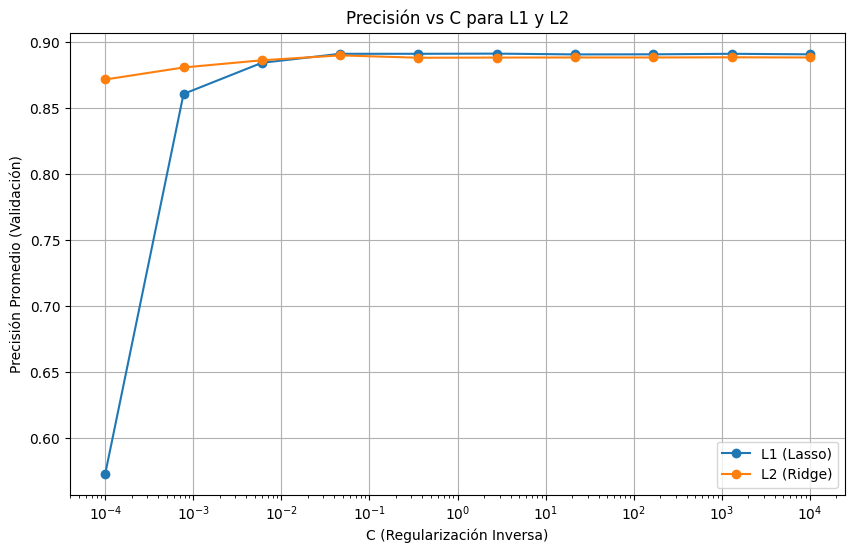

In [21]:
# Graficar precisión promedio para cada C
plt.figure(figsize=(10, 6))
plt.plot(C_values, logreg_l1.scores_[1].mean(axis=0), label='L1 (Lasso)', marker='o')
plt.plot(C_values, logreg_l2.scores_[1].mean(axis=0), label='L2 (Ridge)', marker='o')

plt.xscale('log')  # Escala logarítmica para C
plt.xlabel('C (Regularización Inversa)')
plt.ylabel('Precisión Promedio (Validación)')
plt.title('Precisión vs C para L1 y L2')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Ver los puntajes promedio por validación cruzada para cada C
scores_l1 = logreg_l1.scores_[1].mean(axis=0)  # Precisión promedio para cada valor de C
scores_l2 = logreg_l2.scores_[1].mean(axis=0)

# Mostrar C óptimos
print("Puntajes promedio para L1:", scores_l1)
print("Puntajes promedio para L2:", scores_l2)

# Comprobar el índice del mejor puntaje (C óptimo)
optimal_index_l1 = scores_l1.argmax()
optimal_index_l2 = scores_l2.argmax()

print(f"\nÍndice óptimo para L1: {optimal_index_l1} \nMejor C: {logreg_l1.Cs_[optimal_index_l1]}")
print(f"\nÍndice óptimo para L2: {optimal_index_l2} \nMejor C: {logreg_l2.Cs_[optimal_index_l2]}")

Puntajes promedio para L1: [0.57304267 0.86082682 0.88442111 0.8912666  0.89126658 0.89139949
 0.89080133 0.89086777 0.89126658 0.89086782]
Puntajes promedio para L2: [0.87179324 0.88089852 0.88634842 0.89007028 0.88827597 0.88840888
 0.88847535 0.88847535 0.88860826 0.88847535]

Índice óptimo para L1: 5 
Mejor C: 2.782559402207126

Índice óptimo para L2: 3 
Mejor C: 0.046415888336127774


In [23]:
# Probamos MODELO REGRESION LOGISTICA con este analisis 

# Entrenar el modelo final con el valor óptimo de C
logreg_l1_optimal = LogisticRegression(penalty='l1', solver='liblinear', C=optimal_C_l1, random_state=42, max_iter=1000)
logreg_l2_optimal = LogisticRegression(penalty='l2', solver='liblinear', C=optimal_C_l2, random_state=42, max_iter=1000)

# Entrenar los modelos con el valor de C óptimo
logreg_l1_optimal.fit(X_train, y_train)
logreg_l2_optimal.fit(X_train, y_train)

LogisticRegression(C=np.float64(0.046415888336127774), max_iter=1000,
                   random_state=42, solver='liblinear')

In [24]:
# Realizar predicciones en el conjunto de prueba
y_pred_l1 = logreg_l1_optimal.predict(X_test)
y_pred_l2 = logreg_l2_optimal.predict(X_test)

# Evaluar el desempeño del modelo L1
print("Evaluación del modelo Lasso (L1):")
print("Precisión:", accuracy_score(y_test, y_pred_l1))
print("Reporte de clasificación L1:\n", classification_report(y_test, y_pred_l1))

# Evaluar el desempeño del modelo L2
print("Evaluación del modelo Ridge (L2):")
print("Precisión:", accuracy_score(y_test, y_pred_l2))
print("Reporte de clasificación L2:\n", classification_report(y_test, y_pred_l2))

Evaluación del modelo Lasso (L1):
Precisión: 0.8987240829346093
Reporte de clasificación L1:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1507
           1       0.93      0.90      0.91      2255

    accuracy                           0.90      3762
   macro avg       0.89      0.90      0.90      3762
weighted avg       0.90      0.90      0.90      3762

Evaluación del modelo Ridge (L2):
Precisión: 0.8971291866028708
Reporte de clasificación L2:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1507
           1       0.93      0.90      0.91      2255

    accuracy                           0.90      3762
   macro avg       0.89      0.90      0.89      3762
weighted avg       0.90      0.90      0.90      3762



Coeficientes del modelo Ridge (L2) (ordenados por magnitud):
n_recovery: 0.87957170
n_backs: -0.67269570
n_inc_fees: 0.64663624
n_cr_fe_w: -0.61790659
category_rejected_direct_debit: 0.53308983
n_fees: -0.51331867
transfer_type_regular: -0.34576000
n_inc_back: 0.30913313
inflation: -0.24856478
category_nice: -0.19031175
unemploy_rate: 0.18719534
charge_moment_before: -0.08509568
GBP_EUR: -0.04400043
created_at_dow: -0.01641242
amount: 0.01180765
created_at_slot: 0.00146156
BTC_GBP: -0.00001785

Coeficientes del modelo Lasso (L1) (ordenados por magnitud):
category_rejected_direct_debit: 7.51494901
n_recovery: 0.92684868
n_backs: -0.76557136
n_cr_fe_w: -0.75803910
n_fees: -0.72912467
n_inc_fees: 0.72280439
transfer_type_regular: -0.64901546
inflation: -0.51727654
n_inc_back: 0.33816184
unemploy_rate: 0.33485920
charge_moment_before: 0.22393946
category_nice: 0.11109822
GBP_EUR: -0.04476307
amount: 0.01376490
created_at_dow: -0.01240533
created_at_slot: 0.00050138
BTC_GBP: -0.00019051


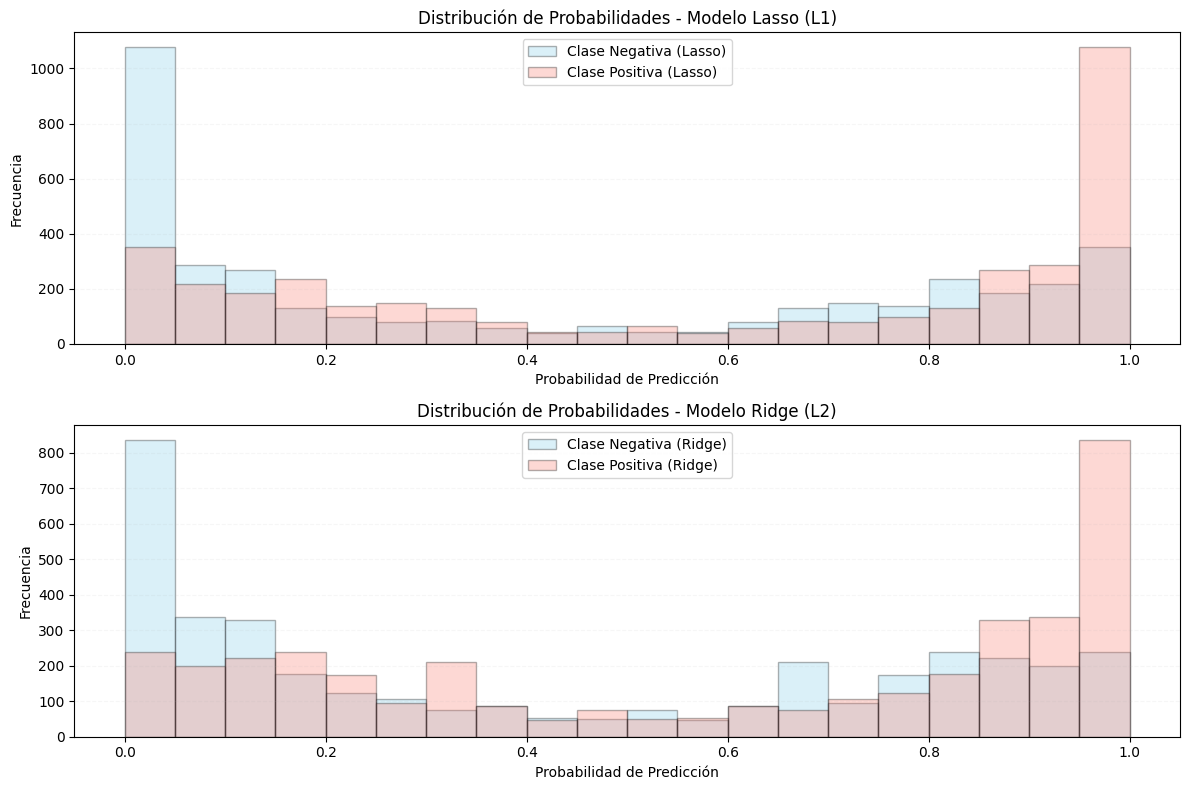

Desempeño del Modelo Lasso (L1):
Accuracy: 0.8987240829346093
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1507
           1       0.93      0.90      0.91      2255

    accuracy                           0.90      3762
   macro avg       0.89      0.90      0.90      3762
weighted avg       0.90      0.90      0.90      3762


Desempeño del Modelo Ridge (L2):
Accuracy: 0.8971291866028708
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1507
           1       0.93      0.90      0.91      2255

    accuracy                           0.90      3762
   macro avg       0.89      0.90      0.89      3762
weighted avg       0.90      0.90      0.90      3762



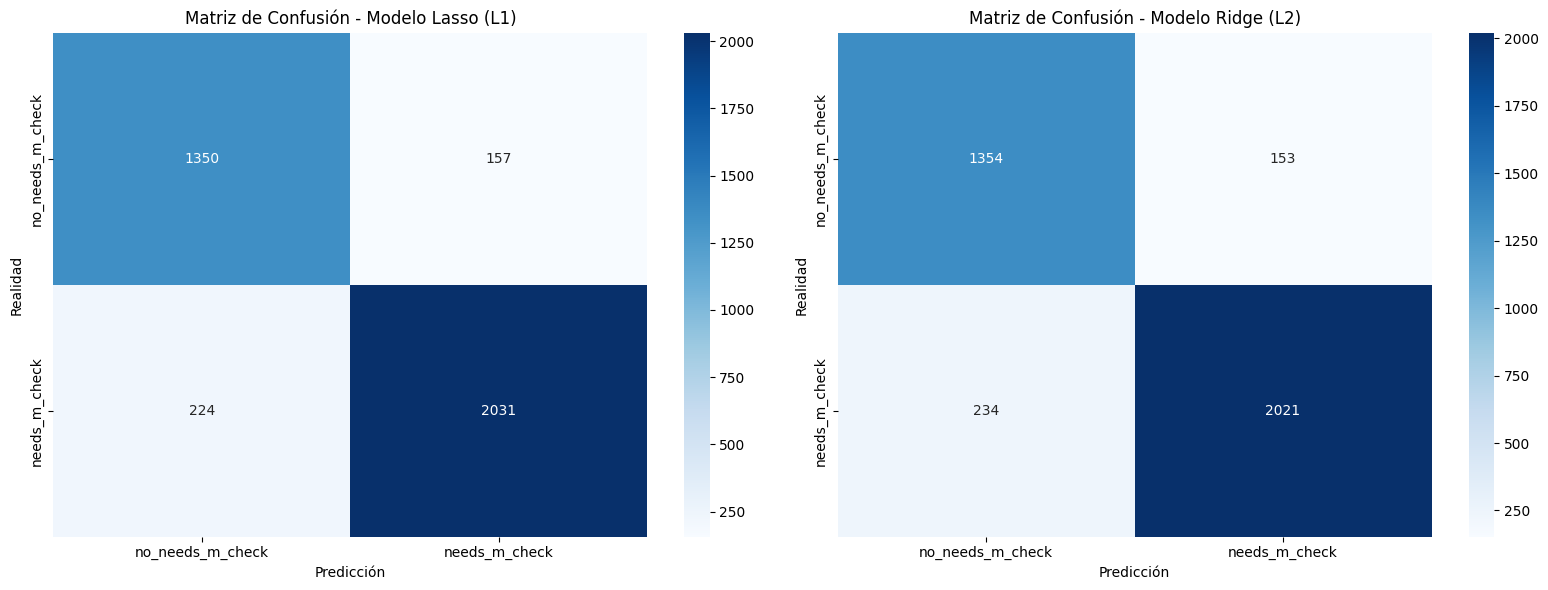

In [25]:
# Genera las probabilidades de predicción para ambos modelos
predicciones_prob_l1 = logreg_l1_optimal.predict_proba(X_test)
predicciones_prob_l2 = logreg_l2_optimal.predict_proba(X_test)

# Obtén los coeficientes de ambos modelos
coef_l1 = logreg_l1_optimal.coef_[0]  # Array unidimensional
coef_l2 = logreg_l2_optimal.coef_[0]

# Asocia los coeficientes con los nombres de las características
feature_coef_l1 = list(zip(feature_names, coef_l1))
feature_coef_l2 = list(zip(feature_names, coef_l2))

# Ordena las características por valor absoluto del coeficiente
feature_coef_l1_sorted = sorted(feature_coef_l1, key=lambda x: abs(x[1]), reverse=True)
feature_coef_l2_sorted = sorted(feature_coef_l2, key=lambda x: abs(x[1]), reverse=True)

# Imprime las características ordenadas por magnitud del coeficiente
print("Coeficientes del modelo Ridge (L2) (ordenados por magnitud):")
for feature, coef in feature_coef_l2_sorted:
    print(f"{feature}: {coef:.8f}")

print("\nCoeficientes del modelo Lasso (L1) (ordenados por magnitud):")
for feature, coef in feature_coef_l1_sorted:
    print(f"{feature}: {coef:.8f}")

# Crea histogramas para ambas clases y modelos
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.hist(predicciones_prob_l1[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Lasso)")
plt.hist(predicciones_prob_l1[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Lasso)")
plt.title("Distribución de Probabilidades - Modelo Lasso (L1)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)

plt.subplot(2, 1, 2)
plt.hist(predicciones_prob_l2[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Clase Negativa (Ridge)")
plt.hist(predicciones_prob_l2[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="Clase Positiva (Ridge)")
plt.title("Distribución de Probabilidades - Modelo Ridge (L2)")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center")
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.tight_layout()
plt.show()

# Evaluación de desempeño para ambos modelos

print("Desempeño del Modelo Lasso (L1):")
print("Accuracy:", logreg_l1_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l1))

print("\nDesempeño del Modelo Ridge (L2):")
print("Accuracy:", logreg_l2_optimal.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_l2))

# Generar matrices de confusión para ambos modelos
matriz_confusion_l1 = confusion_matrix(y_test, y_pred_l1)
matriz_confusion_l2 = confusion_matrix(y_test, y_pred_l2)

# Visualizar matrices de confusión usando mapas de calor
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.heatmap(matriz_confusion_l1, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Lasso (L1)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.subplot(1, 2, 2)
sns.heatmap(matriz_confusion_l2, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.title("Matriz de Confusión - Modelo Ridge (L2)")
plt.xlabel("Predicción")
plt.ylabel("Realidad")

plt.tight_layout()
plt.show()


In [26]:
# Comparación resultados entre MODELO BASE y el modelo entrenado según LASSO y RIDGE

# ROC-AUC para cada modelo
roc_auc_base = roc_auc_score(y_test, predicciones)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Base model
accuracy_base = accuracy_score(y_test, predicciones)
precision_base = precision_score(y_test, predicciones)
recall_base = recall_score(y_test, predicciones)
f1_base = f1_score(y_test, predicciones)
roc_auc_base = roc_auc_score(y_test, predicciones)

# Base model con umbral modificado
accuracy_umbral = accuracy_score(y_test, predicciones_modificadas)
precision_umbral = precision_score(y_test, predicciones_modificadas)
recall_umbral = recall_score(y_test, predicciones_modificadas)
f1_umbral = f1_score(y_test, predicciones_modificadas)
roc_auc_umbral = roc_auc_score(y_test, predicciones_modificadas)

# Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_l2)
precision_ridge = precision_score(y_test, y_pred_l2)
recall_ridge = recall_score(y_test, y_pred_l2)
f1_ridge = f1_score(y_test, y_pred_l2)
roc_auc_ridge = roc_auc_score(y_test, y_pred_l2)

# Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_l1)
precision_lasso = precision_score(y_test, y_pred_l1)
recall_lasso = recall_score(y_test, y_pred_l1)
f1_lasso = f1_score(y_test, y_pred_l1)
roc_auc_lasso = roc_auc_score(y_test, y_pred_l1)

# Comparar métricas clave en una tabla

metricas = {
    "R_LOG StandardScaler": ["Base", "Umbral 0.4","Ridge", "Lasso"],
    "Accuracy": [accuracy_base, accuracy_umbral ,accuracy_ridge, accuracy_lasso],
    "Precision": [precision_base, precision_umbral,precision_ridge, precision_lasso],
    "Recall": [recall_base, recall_umbral, recall_ridge, recall_lasso],
    "F1-Score": [f1_base, f1_umbral, f1_ridge, f1_lasso],
    "ROC-AUC": [roc_auc_base, roc_auc_umbral, roc_auc_ridge, roc_auc_lasso],
}

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


  R_LOG StandardScaler  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0                 Base  0.896598   0.929163  0.895787  0.912170  0.896799
1           Umbral 0.4  0.892079   0.903184  0.918404  0.910730  0.885546
2                Ridge  0.897129   0.929623  0.896231  0.912621  0.897352
3                Lasso  0.898724   0.928245  0.900665  0.914247  0.898242


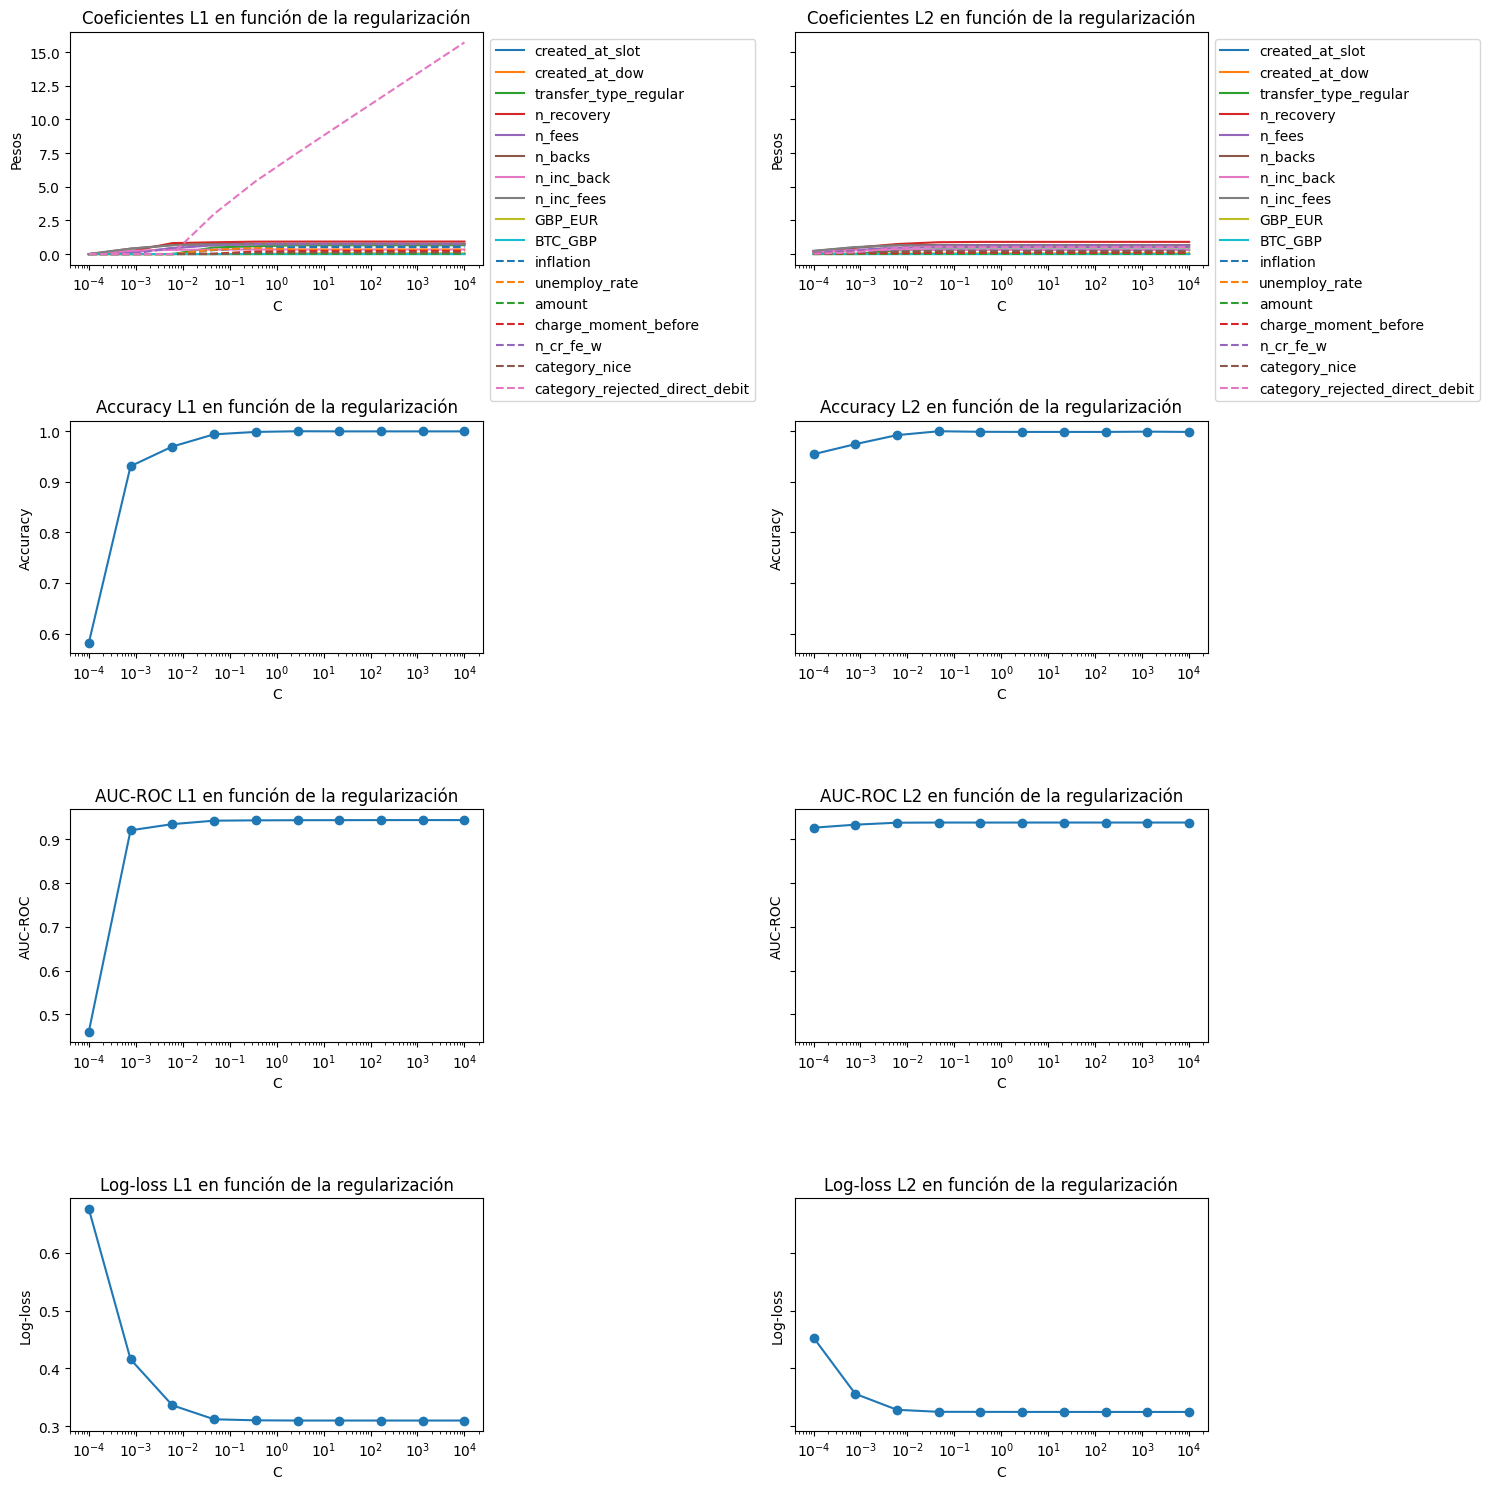

In [29]:
# Graficar el C (que es 1/alpha)

# Valores de C para probar (equivalente a 1/alpha en regresión logística)
C_values = np.logspace(-4, 4, 10)

# Inicialización de listas para almacenar resultados
coefs_logreg_l1 = []
coefs_logreg_l2 = []
accuracy_l1 = []
accuracy_l2 = []
auc_l1 = []
auc_l2 = []
logloss_l1 = []
logloss_l2 = []

# Modelos y evaluación
for C in C_values:
    # Penalización L1
    logreg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000, random_state=42)
    logreg_l1.fit(X_train, y_train)
    coefs_logreg_l1.append(logreg_l1.coef_[0])  # Guardar coeficientes
    y_pred_prob_l1 = logreg_l1.predict_proba(X_test)[:, 1]  # Probabilidades para ROC y log-loss
    accuracy_l1.append(logreg_l1.score(X_test, y_pred_l1))
    auc_l1.append(roc_auc_score(y_test, y_pred_prob_l1))  # AUC-ROC
    logloss_l1.append(log_loss(y_test, y_pred_prob_l1))  # Log-loss

    # Penalización L2
    logreg_l2 = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=1000, random_state=42)
    logreg_l2.fit(X_train, y_train)
    coefs_logreg_l2.append(logreg_l2.coef_[0])  # Guardar coeficientes
    y_pred_prob_l2 = logreg_l2.predict_proba(X_test)[:, 1]
    accuracy_l2.append(logreg_l2.score(X_test, y_pred_l2))
    auc_l2.append(roc_auc_score(y_test, y_pred_prob_l2))  # AUC-ROC
    logloss_l2.append(log_loss(y_test, y_pred_prob_l2))  # Log-loss


# Configuración del gráfico
fig, axs = plt.subplots(4, 2, figsize=(15, 15), sharey='row')

# Definir los colores y estilos de línea
colors = plt.cm.tab10.colors  # Paleta de colores
line_styles = ['-', '--', '-.', ':']  # Diferentes tipos de línea

# Coeficientes L1
for i, coef in enumerate(np.abs(coefs_logreg_l1).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 0].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 0].set_xscale('log')
axs[0, 0].set_title('Coeficientes L1 en función de la regularización')
axs[0, 0].set_xlabel('C')
axs[0, 0].set_ylabel('Pesos')
axs[0, 0].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,0].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

# Coeficientes L2
for i, coef in enumerate(np.abs(coefs_logreg_l2).T):
    # El color se toma de la paleta y el estilo de línea se alterna según el índice
    color = colors[i % 10]  # Asignar uno de los primeros 10 colores
    line_style = line_styles[i // 10 % len(line_styles)]  # Alternar entre los diferentes tipos de línea cada 10
    axs[0, 1].plot(C_values, coef, label=feature_names[i], color=color, linestyle=line_style)

axs[0, 1].set_xscale('log')
axs[0, 1].set_title('Coeficientes L2 en función de la regularización')
axs[0, 1].set_xlabel('C')
axs[0, 1].set_ylabel('Pesos')
axs[0, 1].legend(feature_names)

# Coloca la leyenda fuera del gráfico
axs[0,1].legend(feature_names, loc='upper left', bbox_to_anchor=(1, 1))

#Graficar Accuracy para ver como varia un función de las C
# Accuracy L1
axs[1, 0].plot(C_values, accuracy_l1, marker='o')
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('Accuracy L1 en función de la regularización')
axs[1, 0].set_xlabel('C')
axs[1, 0].set_ylabel('Accuracy')

# Accuracy L2
axs[1, 1].plot(C_values, accuracy_l2, marker='o')
axs[1, 1].set_xscale('log')
axs[1, 1].set_title('Accuracy L2 en función de la regularización')
axs[1, 1].set_xlabel('C')
axs[1, 1].set_ylabel('Accuracy')

#Graficar AUC-ROC para ver como cambia rendimiento del modelo en términos de discriminación entre las clases postiva y negativa
# AUC-ROC L1
axs[2, 0].plot(C_values, auc_l1, marker='o')
axs[2, 0].set_xscale('log')
axs[2, 0].set_title('AUC-ROC L1 en función de la regularización')
axs[2, 0].set_xlabel('C')
axs[2, 0].set_ylabel('AUC-ROC')

# AUC-ROC L2
axs[2, 1].plot(C_values, auc_l2, marker='o')
axs[2, 1].set_xscale('log')
axs[2, 1].set_title('AUC-ROC L2 en función de la regularización')
axs[2, 1].set_xlabel('C')
axs[2, 1].set_ylabel('AUC-ROC')

# Graficar Log-loss para ver como cambia la calidad de las predicciones (mide la perdida del modelo,los errores q hace)
# Log-loss L1
axs[3, 0].plot(C_values, logloss_l1, marker='o')
axs[3, 0].set_xscale('log')
axs[3, 0].set_title('Log-loss L1 en función de la regularización')
axs[3, 0].set_xlabel('C')
axs[3, 0].set_ylabel('Log-loss')

# Log-loss L2
axs[3, 1].plot(C_values, logloss_l2, marker='o')
axs[3, 1].set_xscale('log')
axs[3, 1].set_title('Log-loss L2 en función de la regularización')
axs[3, 1].set_xlabel('C')
axs[3, 1].set_ylabel('Log-loss')

plt.tight_layout()
plt.show()


Total de muestras: 500
500


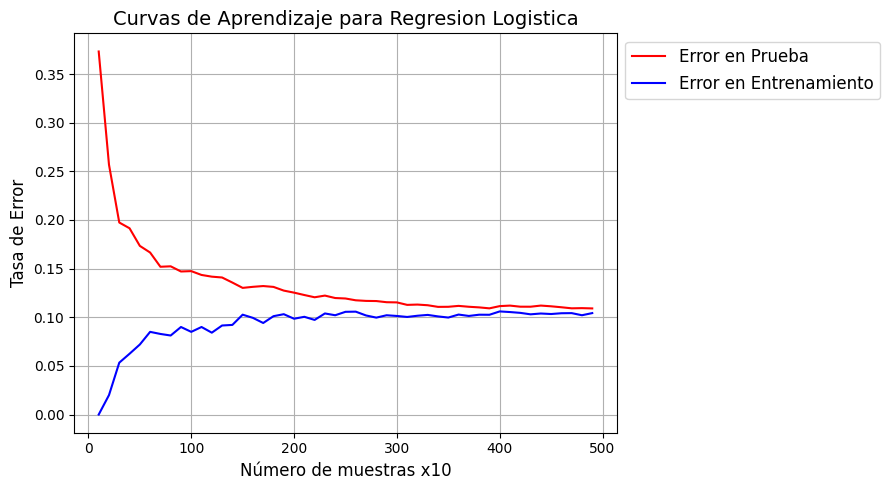

In [28]:
# Graficar curvas de error. 

np.random.seed(42)
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #, random_state=42)
#display(X_test)
#display(y_test)

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()